In [1]:
from gorgo import infer, condition, draw_from, flip, keep_deterministic, mem
from gorgo.hashable import hashabledict

from collections import namedtuple
import math
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# define named tuples
Utterance = namedtuple("Utterance", ("subj", "feature"))
Instance = namedtuple("Instance", ("kind", "features"))
Kind = namedtuple("Kind", ("name", "features"))

# equivalent to:
# class Utterance:
#     def __init__(self, subj, feature):
#         self.subj = subj`
#         self.feature = feature`


# helper functions
## convert gorgo dist to df for plotting
@keep_deterministic
def dist_to_df(dist):
    df_dist = pd.DataFrame(dist.support)
    df_dist['Probability'] = dist.probabilities
    return df_dist

## memo-ized, so that feeding in same feature returns same kind-linked status each time
@mem
def is_zarpie_feature(feature, coherence):
    return flip(coherence)


# Modeling inferences about category coherence from generics

* **listener**: considering only the *features observed so far*
* **speaker**: trying to communicate which *of the features observed* is kind-linked

## Literal listener

**Meaning function**

* Features are either kind-linked or not kind-linked. 
* A *generic statement* is true if the mentioned feature $f$ is in the set of features true of the category (i.e., the property is kind-linked).
* A *specific statement* is true if the mentioned feature $f$ is in the set of features true of the individual. 
* eq. 1:

$$[[u_i]](\mathcal{F}_k, x_i) = 
\begin{cases}
1[f \in \mathcal{F}_k] \text{, if } u_i = \text{"$k$s are $f$"}\\
1[f \in x_i] \text{, if } u_i = \text{"This $k$ is $f$"}\\
0 \text{, otherwise}
\end{cases}$$

In [3]:
# meaning function
def meaning(kind: Kind, inst: Instance, utt: Utterance):
    if "This" in utt.subj: # specific
        return utt.feature in inst.features  # specific is true = mentioned feature is in list of example instance's features
    elif "Zarpies" in utt.subj: # generic
        return utt.feature in kind.features   # generic is true = mentioned feature is in list of kind-linked features
    elif "silence" in utt.subj: # silence
        return True
    else:
        return True


**Literal listener** is simultaneously inferring $\mathcal{F}_k$ (set of kind-linked features, **out of the features of observed individuals**) and $\theta$ (category coherence) from the literal meaning of the speaker's utterances $u$ about observed instance $x$ (eq. 2):

$$\text{Lit}(\mathcal{F}_k, \theta | x, u) \propto P(\theta)P(\mathcal{F}_k|\theta)\prod_{i}[[u_i]](\mathcal{F}_k, x_i)$$

* $\mathcal{F}_k$ = set of **kind-linked features**, a subset of features observed so far
* $\theta =P(f \in \mathcal{F}_k)$ = **category coherence** of kind = likelihood that any feature will be kind-linked
* $x$, $u$ = set of pairs of **observed instances and utterances**

<!-- -->

* $P(\theta)$ = **prior on coherence**
* $P(\mathcal{F}_k|\theta)$ = $\prod_{f_i \in \mathcal{F}}P(f_i \in \mathcal{F}_k | \theta)$ = **kind feature likelihood** = likelihood of a given set of kind-linked features $\mathcal{F}_k$ given the coherence $\theta$
* $\prod_{i}[[u_i]](\mathcal{F}_k, x_i)$ = **meaning** of utterance given instance, via meaning function, for all utterance-instance pairs in data


In [4]:
@infer
def literal_listener(data: tuple[tuple[Utterance, Instance]]):
    # sample a coherence
    coherence = draw_from([.1, .2, .3, .4, .5, .6, .7, .8, .9])

    # incrementally build out feature list from data
    observed_features_so_far = ()
    zarpie_features_so_far = ()
    
    # for each utterance-instance pair in data:
    for pair in data:
        # get utterance and instance
        utt = pair[0]
        inst = pair[1]
        
        # flip observed features & add to feature list
        for feature in inst.features:
            observed_features_so_far = observed_features_so_far + (feature, )
            if(is_zarpie_feature(feature, coherence)):
                zarpie_features_so_far = zarpie_features_so_far + (feature, )
        
        # convert to tuple; set discards duplicate features
        observed_features_so_far = tuple(set(observed_features_so_far))
        zarpie_features_so_far = tuple(set(zarpie_features_so_far))
        
        # define zarpie concept to have those features
        zarpies = Kind("Zarpies", zarpie_features_so_far)
        
        # get truth-value of utterance
        semantic_likelihood = meaning(kind = zarpies, inst = inst, utt = utt)
        
        # condition softly on truth-value (sometimes speaker misspeaks and feature is not true)
        condition(.95 if semantic_likelihood else .05)
    
    # define zarpie concept to have those features
    zarpies = Kind("Zarpies", zarpie_features_so_far)
    
    return hashabledict(zarpie_features = zarpies.features, coherence = coherence)
    # return "jumps over puddles" in zarpies.features

In [5]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
    (Utterance(subj='Zarpies', feature='jump over puddles'), 
     Instance(kind='Zarpie', features=('jump over puddles', 'eats flowers', 'is 20 years old'))),
)

literal_listener(data)

DiscreteInferenceResult(support=({'zarpie_features': ('jump over puddles', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('eats flowers',), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.1}, {'zarpie_features': (), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'jump over puddles'), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.1}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('scared of shadows', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.1}, {'zarpie_features': ('jump over puddles', 'scared of shadows'), 'coherence': 0.1}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'scared of shadows'), 'coherence': 0.1}, {'zarpie_features': ('jump over puddles', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('eats flowers',), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('scared of shadows', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.3}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'jump over puddles'), 'coherence': 0.3}, {'zarpie_features': (), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.3}, {'zarpie_features': ('jump over puddles', 'scared of shadows'), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.3}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'scared of shadows'), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('jump over puddles', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('eats flowers',), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': ('jump over puddles', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'jump over puddles'), 'coherence': 0.7}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.7}, {'zarpie_features': (), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.9}, {'zarpie_featur

### Model predictions

#### Hearing a generic

hearing "Zarpies eat flowers" about a Zarpie that eats flowers

In [7]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', ))),
)

In [8]:
# run literal listener
dist = literal_listener(data)

# convert inferred set of zarpie features & coherence to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

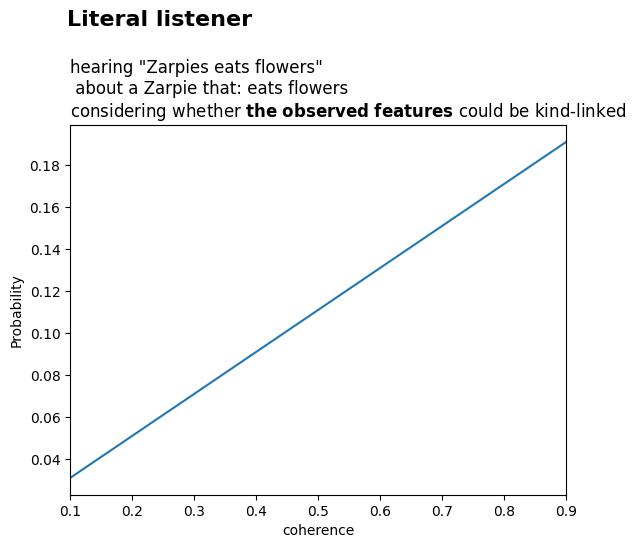

In [9]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_1_coherence.png", bbox_inches = "tight")
plt.show(g)

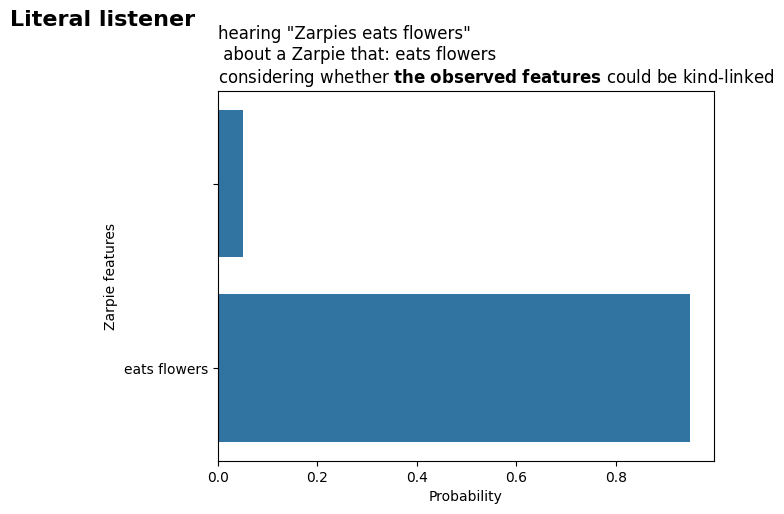

In [10]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_1_features.png", bbox_inches = "tight")
plt.show(g)

hearing "Zarpies eat flowers" about a Zarpie that eats flowers and sings lovely songs

In [11]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
)

# run literal listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')


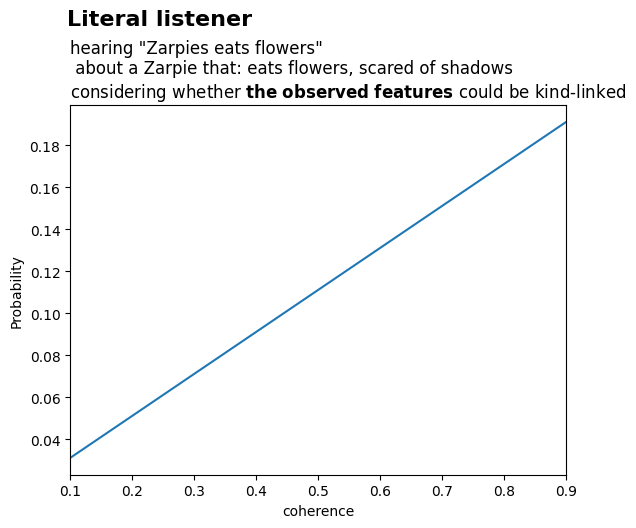

In [12]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_2_coherence.png", bbox_inches = "tight")
plt.show(g)

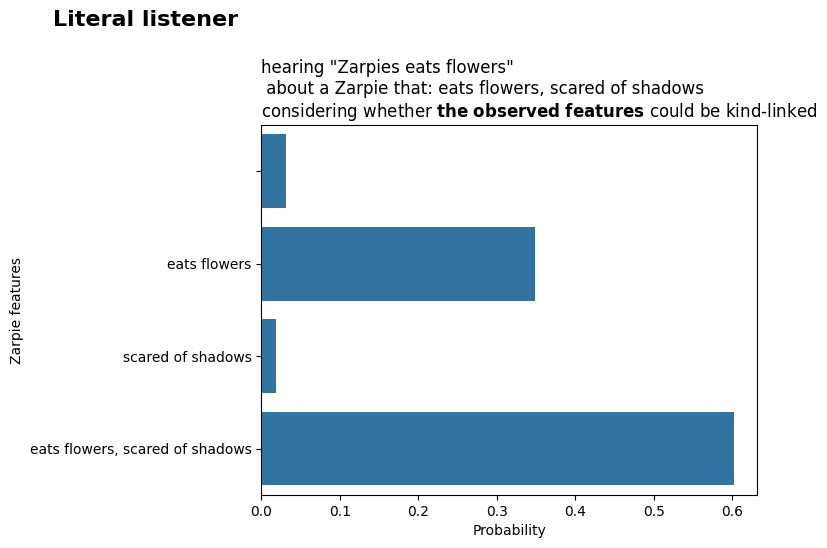

In [13]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Hearing a specific

* specifics are treated as irrelevant to coherence, and to kind status of the mentioned feature or unmentioned features

In [14]:
# set up data
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), Instance(kind='Zarpie', features=('eats flowers',))) ,
    )

# run literal listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

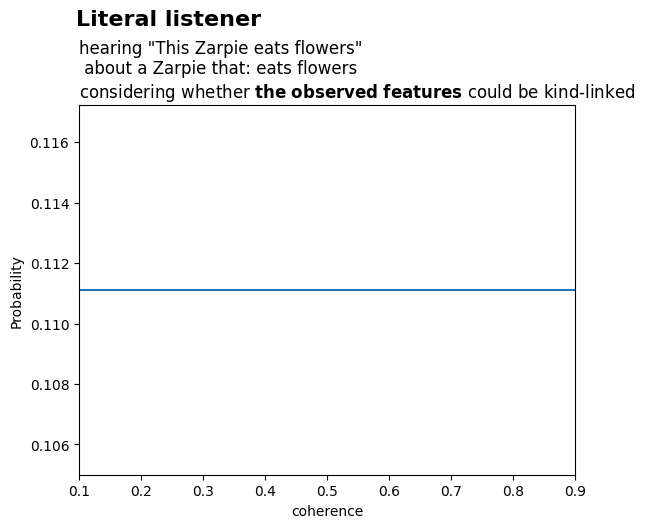

In [15]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_specific_1_coherence.png", bbox_inches = "tight")
plt.show(g)

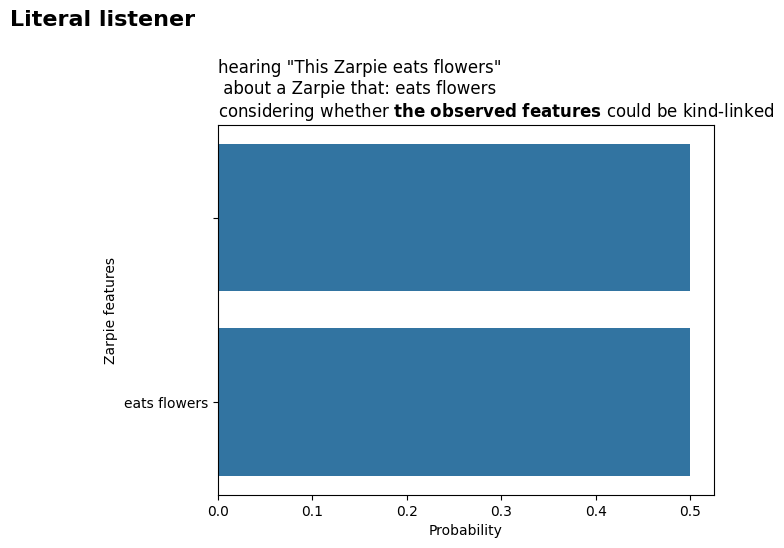

In [16]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_specific_1_features.png", bbox_inches = "tight")
plt.show(g)

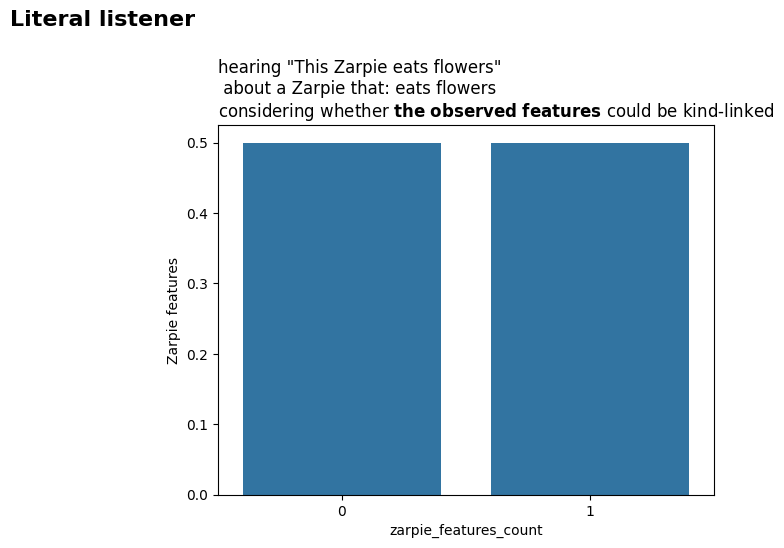

In [17]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_specific_1_featurescount.png", bbox_inches = "tight")
plt.show(g)

#### Hearing multiple trials

In [18]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers",))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows",)))
)

In [19]:
# run pragmatic listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

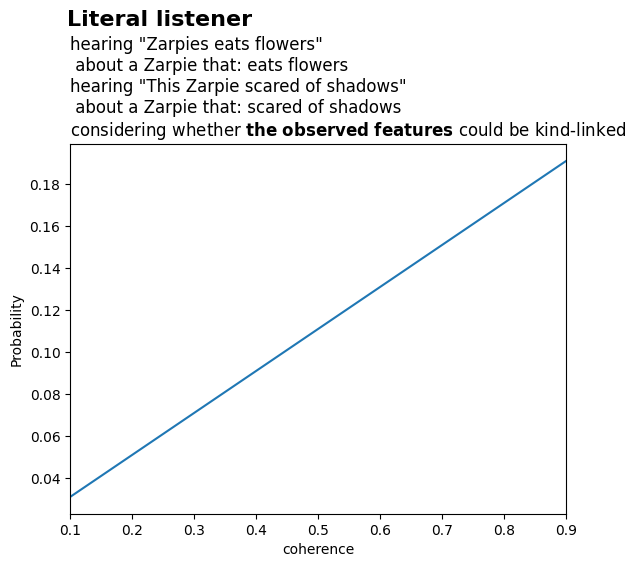

In [20]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_multiple_1_coherence.png", bbox_inches = "tight")
plt.show(g)

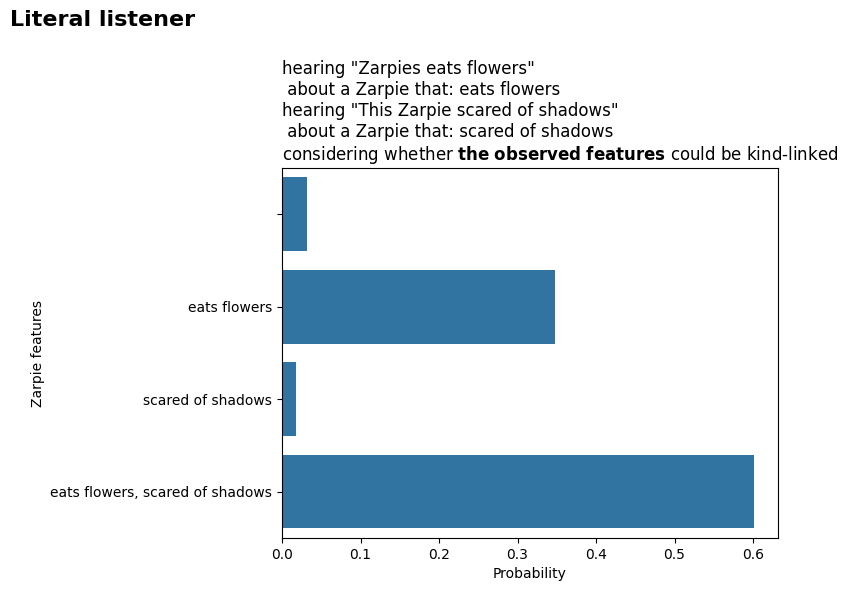

In [21]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_multiple_1_features.png", bbox_inches = "tight")
plt.show(g)

## Speaker

* **Jaccard similarity**: ranges between 0 and 1 for two sets $A$ and $B$ (footnote 1):

$$\text{Similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

* **utility function**: speaker is trying to align what their listener infers about the observed features of the individual $\mathcal{F}_k$ with the true kind-linked status of those features $\mathcal{F}_k^*$ (eq. 4, the note below eq. 4):
    * First term - literal listener's posterior probability of kind-linked features, out of the individual's features
    * Second term - similarity between that set of features and the true kind-linked status of those features
    * Multiplying them for each Fk, and then summing over all Fks in the distribution, gives you the expected utility

$$\text{Utility}(u_i, x_i, \mathcal{F}_k^*) = \sum_{\mathcal{F}_k} \text{Lit}(\mathcal{F}_k|x_i, u_i) \cdot \text{Similarity}(\mathcal{F}_k^* \cup x_i, \mathcal{F}_k \cup x_i)$$

$$\text{Lit}(\mathcal{F}_k|x_i, u_i) = \int \text{Lit}(\mathcal{F}_k, \theta | x_i, u_i)d\theta$$


In [6]:
def jaccard_similarity(set_a, set_b):
    if len(set_a) == 0 and len(set_b) == 0:
        return 1 # if both lists are empty, return 1
    else:
        return len(set.intersection(set_a, set_b)) \
            / len(set.union(set_a, set_b))

In [7]:
@keep_deterministic
def utility_func(pair: tuple[Utterance, Instance],
                 kind_features: tuple[str, ...]):
    # run literal listener
    data = (pair, )
    dist = literal_listener(data)
    
    utt = pair[0]
    inst = pair[1]
    
    # only seen one trial
    observed_features_so_far = inst.features
    
    # compare similarity of inferred kind-linked features to true kind features
    def f(x):
        
        # NOTE: restricted to observed features from data
        return jaccard_similarity(set(kind_features) & set(observed_features_so_far), 
                                  set(x["zarpie_features"]) & set(observed_features_so_far))
        
        ## NOTE: across all kind-linked features known to the speaker
        # return jaccard_similarity(set(kind_features), 
        #                           set(x["zarpie_features"]))
    
    # calculate expected value over all sets of features, collapsing across coherence
    exp_utility = dist.expected_value(f)
    
    return exp_utility


* **speaker**: speaker is trying to maximize utility with some rationality/inverse temp $\beta$ (eq. 5):

$$\text{Speaker}(u_i|\mathcal{F}_k^*, x_i) \propto \text{exp}(\beta \cdot \text{Utility}(u_i, x_i, \mathcal{F}_k^*))$$

In [8]:
@infer
def speaker(kind_features: Kind.features, observed_instance: Instance, inv_temp = 2):
    utt = Utterance(subj = draw_from(["Zarpies", "This Zarpie", "silence"]),       # consider saying generic or specific..
                    feature = draw_from(observed_instance.features))    # ..about some feature of observed instance
    utility = utility_func((utt, observed_instance), 
                           kind_features)                               # consider what literal listener will infer (about zarpie features, coherence) from utterance
                                                                        # how close is literal listener's inferences to true zarpie features
    # weight = utility**inv_temp                                        # maximize utility, with inv_temp rationality
    weight = math.exp(inv_temp*utility)                                 # version to avoid issues with 0 utility
    condition(weight)
    
    return utt

### Model predictions

In [9]:
# set up kind-linked features
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features

# set up instance in data
example_zarpie = Instance("Zarpies", ("eats flowers", ))    # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)

dist

subj,feature,Probability
Zarpies,eats flowers,0.552
This Zarpie,eats flowers,0.224
silence,eats flowers,0.224


In [26]:
# FIXME
# dist.marginalize(lambda x: Utterance(subj='Zarpies', feature='eats flowers') in x['Utterance'])
# dist.marginalize(lambda x: len(x['zarpie_features']))
# dist.marginalize(lambda x: x['coherence'])
# dist.marginalize(lambda x: "scared of shadows" in x['zarpie_features'])
# dist.marginalize(lambda x: "sings lovely songs" in x['zarpie_features']).prob(True)

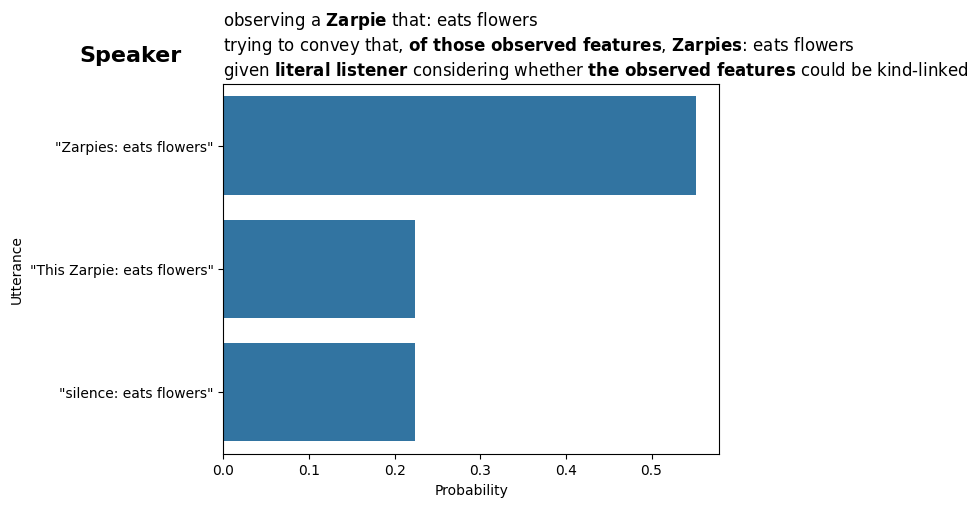

In [10]:
# convert to data frame
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker_kindlinked.png", bbox_inches = "tight")
plt.show(g)

#### No generic exaggeration effect

* **Generic exaggeration effect** - speaker more likely to say a generic about a feature true of individual but not true of kind, over a specific, to get listener to believe the kind does share other features that it does in fact share

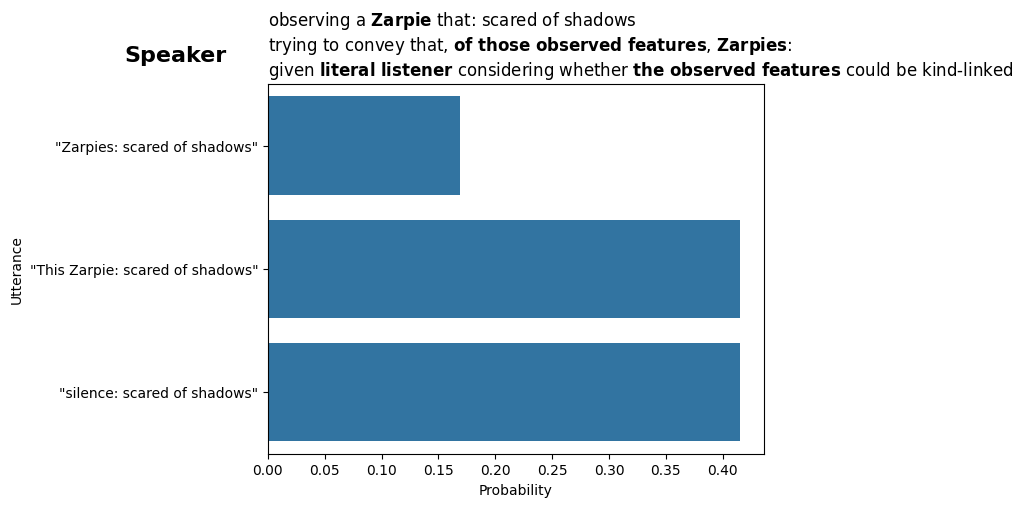

In [11]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("scared of shadows", ))    # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

# convert to data frame
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker_1idiosyncratic.png", bbox_inches = "tight")
plt.show(g)

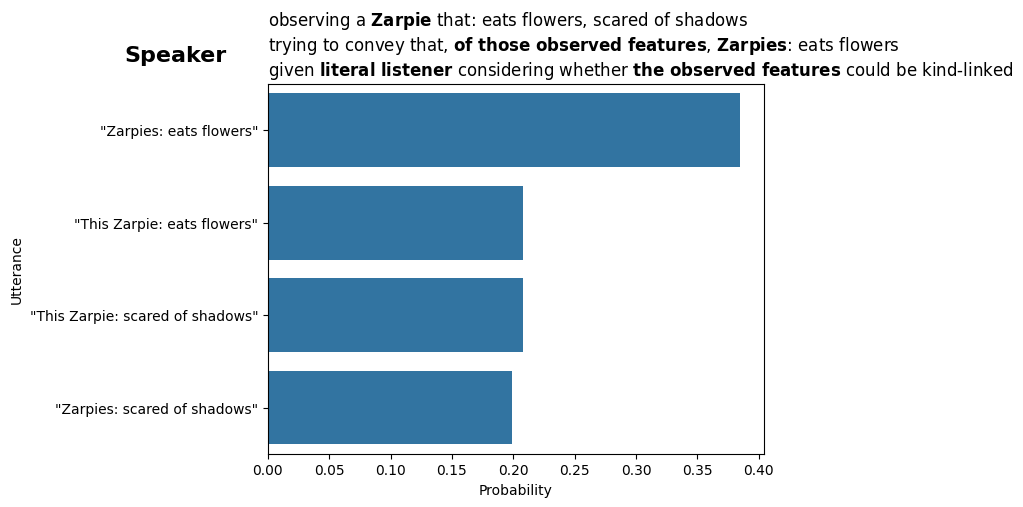

In [29]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", "scared of shadows"))             # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

# convert to data frame
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker_1kindlinked_1idiosyncratic.png", bbox_inches = "tight")
plt.show(g)

## Pragmatic listener

Pragmatic listener is reasoning, not about literal truth-value of utterances, but about likelihood that a speaker reasoning about a literal listener will produce the utterance. 

Replace the literal semantics likelihood in Equation 2 with the speaker likelihood (Equation 5) to make eq. 6:

$$\text{Prag}(\mathcal{F}_k, \theta | x, u) \propto P(\theta)P(\mathcal{F}_k|\theta)\prod_{i}\text{Sp}(u_i|\mathcal{F}_k, x_i)$$

In [12]:
# this needs to be kept deterministic since 
# marginalize is being transformed, which we do not want
@keep_deterministic
def calc_utt_likelihood(features, inst, utt):
    # run speaker model
    dist = speaker(features, inst)
    # what is likelihood of saying the utterance heard (over all coherences)
    utt_likelihood = dist.marginalize(lambda x: utt == x).prob(True)
    return utt_likelihood

In [13]:
@infer
def pragmatic_listener(data: tuple[tuple[Utterance, Instance]]):
    # sample a coherence
    coherence = draw_from([.1, .2, .3, .4, .5, .6, .7, .8, .9])
    
    # incrementally build out feature list from data
    observed_features_so_far = ()
    zarpie_features_so_far = ()
    
    # for each utterance-instance pair in data:
    for pair in data:
        # get utterance and instance
        utt = pair[0]
        inst = pair[1]
        
        # flip observed features & add to feature list
        for feature in inst.features:
            observed_features_so_far = observed_features_so_far + (feature, )
            if(is_zarpie_feature(feature, coherence)):
                zarpie_features_so_far = zarpie_features_so_far + (feature, )
        
        # convert to tuple; set discards duplicate features
        observed_features_so_far = tuple(set(observed_features_so_far))
        zarpie_features_so_far = tuple(set(zarpie_features_so_far))
        
        # define zarpie concept to have those features
        zarpies = Kind("Zarpies", zarpie_features_so_far)
        
        # run speaker on hypothesized zarpie features, instance
        # likelihood = speaker's probability of saying the utterance
        # cf. literal listener, which uses literal meaning as likelihood
        utt_likelihood = calc_utt_likelihood(zarpies.features, inst, utt)
        
        # condition on speaker likelihood
        condition(utt_likelihood)
    
    # define zarpie concept to have those features
    zarpies = Kind("Zarpies", zarpie_features_so_far)
    
    return hashabledict(zarpie_features = zarpies.features, coherence = coherence)
    # return "jumps over puddles" in zarpies.features

### Model predictions

#### Hearing a generic

In [14]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), Instance(kind='Zarpie', features=('eats flowers', ))),
)

In [15]:
# run pragmatic_listener
dist = pragmatic_listener(data)

# convert inferred set of zarpie features & coherence to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

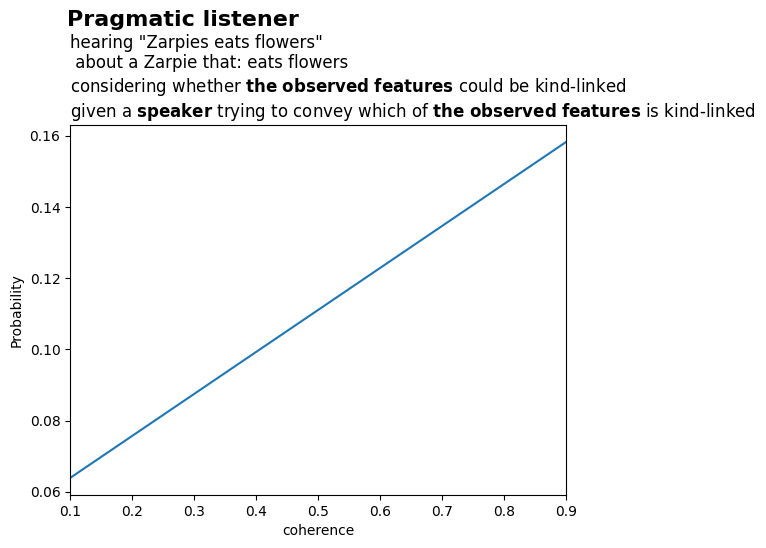

In [16]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_1_coherence.png", bbox_inches = "tight")
plt.show(g)

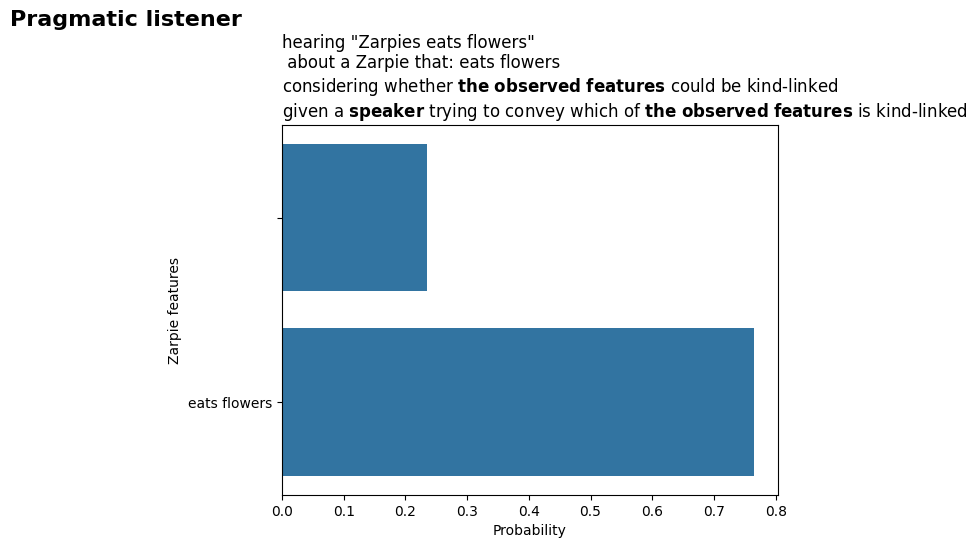

In [17]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_1_features.png", bbox_inches = "tight")
plt.show(g)

In [18]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
)

In [19]:
# run pragmatic_listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

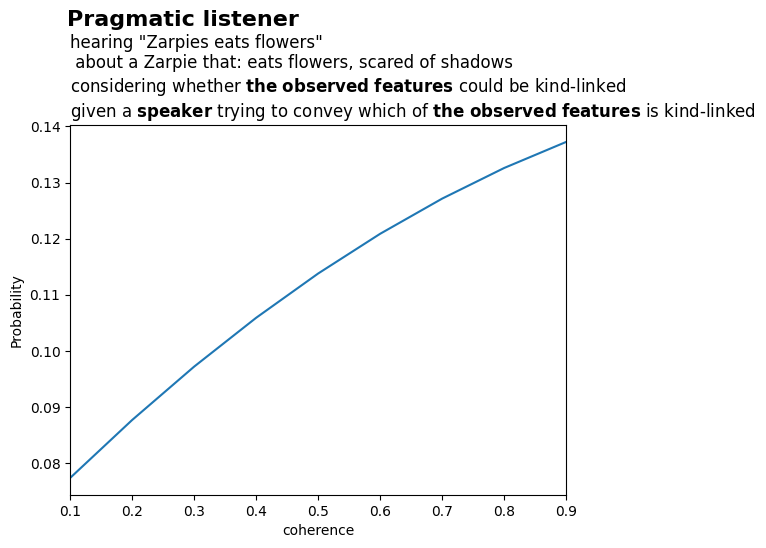

In [20]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_2_coherence.png", bbox_inches = "tight")
plt.show(g)

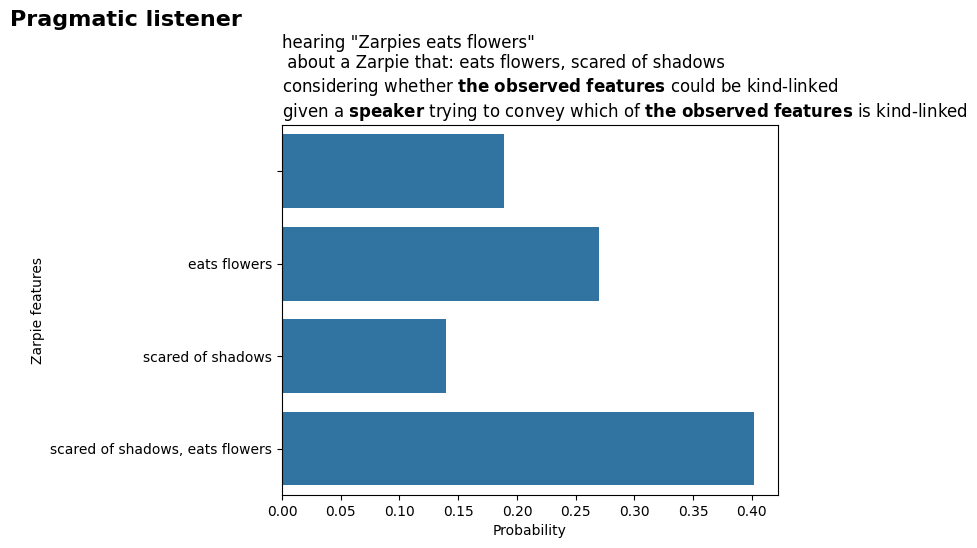

In [21]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Hearing a specific

In [22]:
# set up trial
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', ))) ,
)

# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

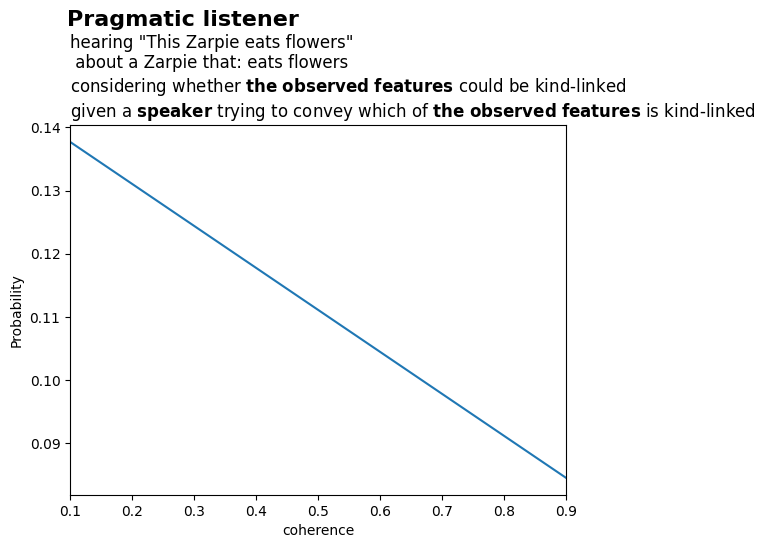

In [23]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_1_coherence.png", bbox_inches = "tight")
plt.show(g)

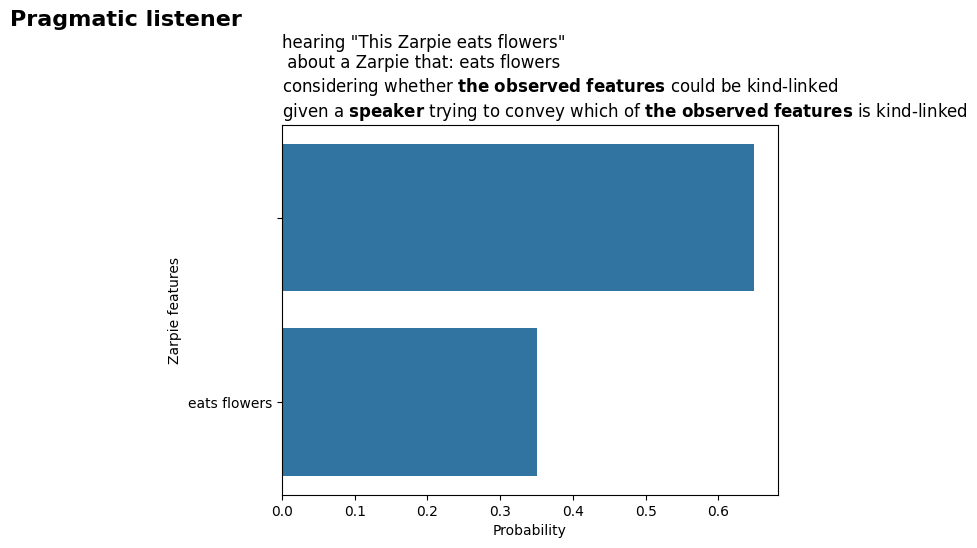

In [24]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_1_features.png", bbox_inches = "tight")
plt.show(g)

In [25]:
# set up trial
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))) ,
)

# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

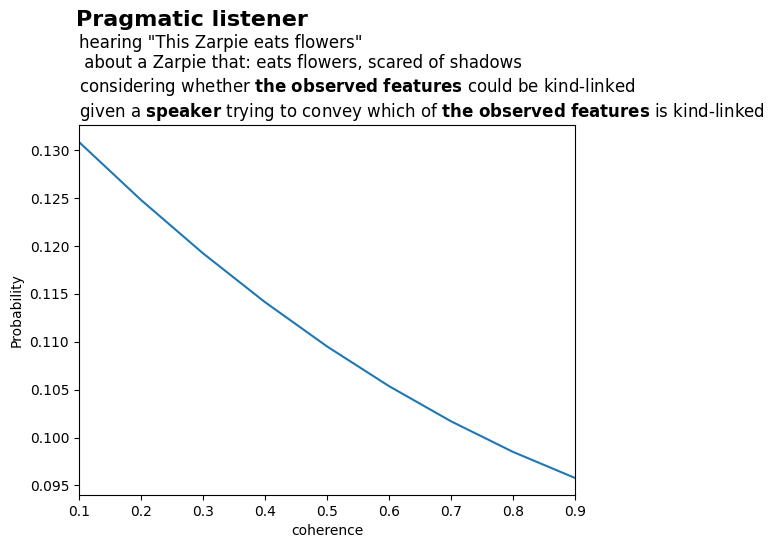

In [26]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_2_coherence.png", bbox_inches = "tight")
plt.show(g)

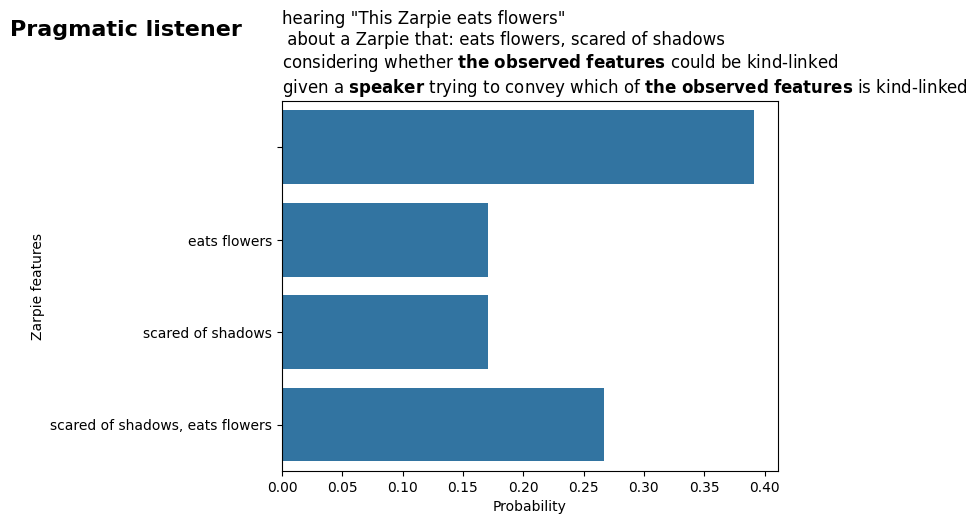

In [27]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_2_features.png", bbox_inches = "tight")
plt.show(g)

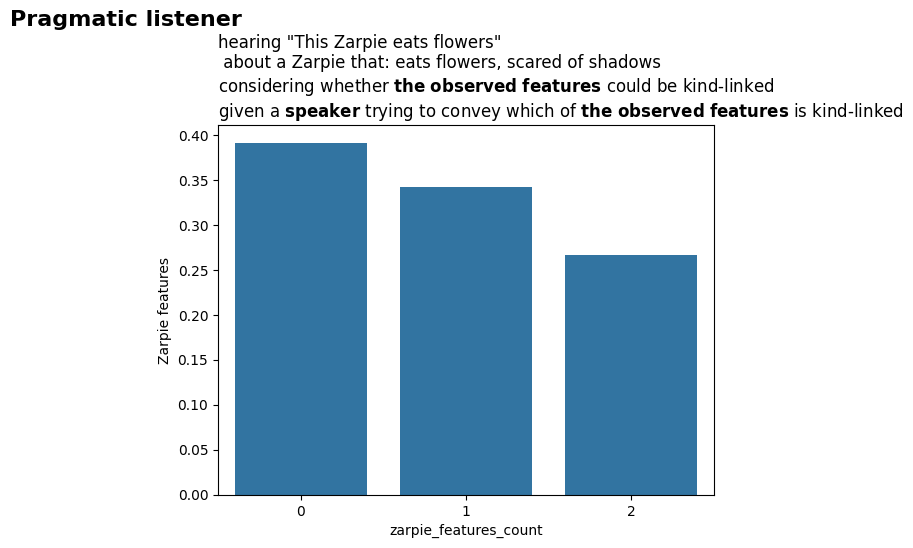

In [28]:
# plot number of inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_2_featurescount.png", bbox_inches = "tight")
plt.show(g)

#### Hearing multiple trials

In [29]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers", ))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows", )))
)

In [30]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

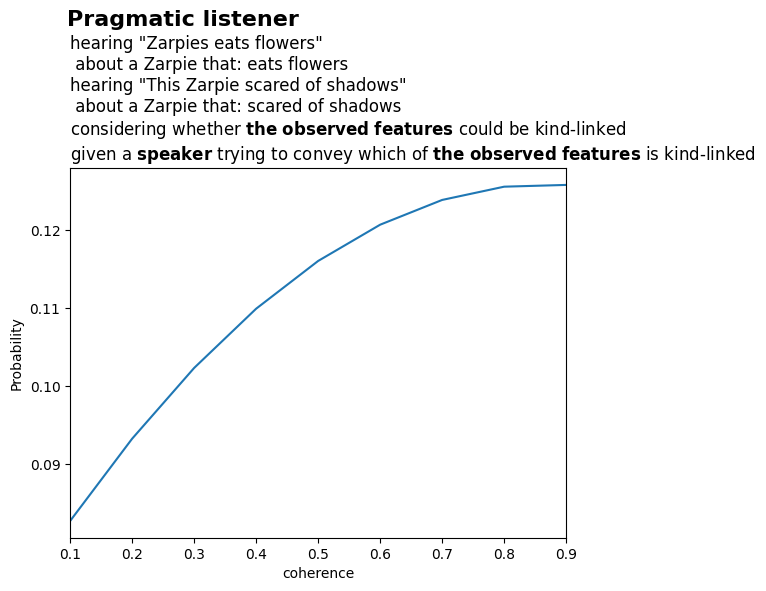

In [31]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_1_coherence.png", bbox_inches = "tight")
plt.show(g)

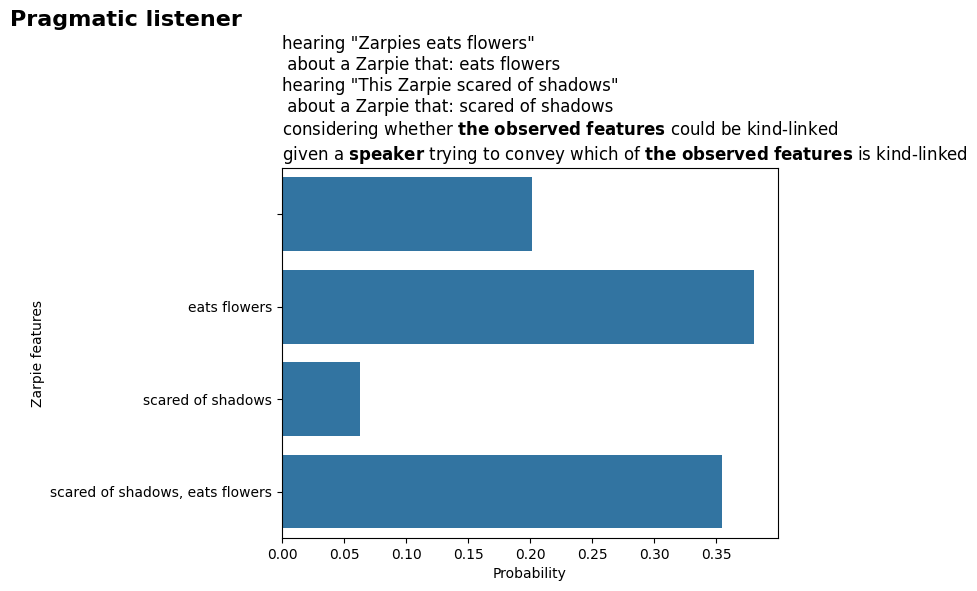

In [32]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_1_features.png", bbox_inches = "tight")
plt.show(g)

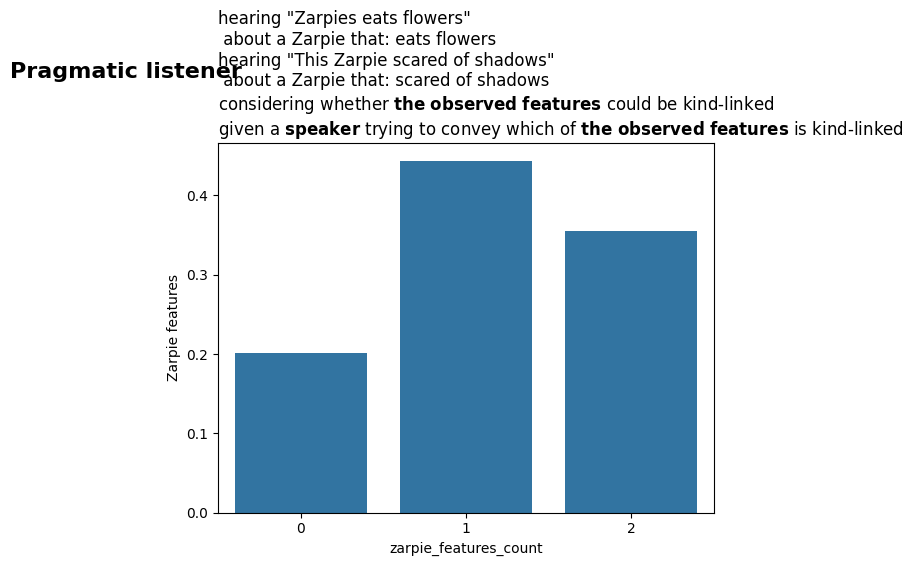

In [33]:
# plot number of inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.2, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_1_featurescount.png", bbox_inches = "tight")
plt.show(g)

In [52]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers", ))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows", ))),
    (Utterance("This Zarpie", "jumps over puddles"), Instance("Zarpie", ("jumps over puddles", "sings lovely songs")))
)

In [53]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

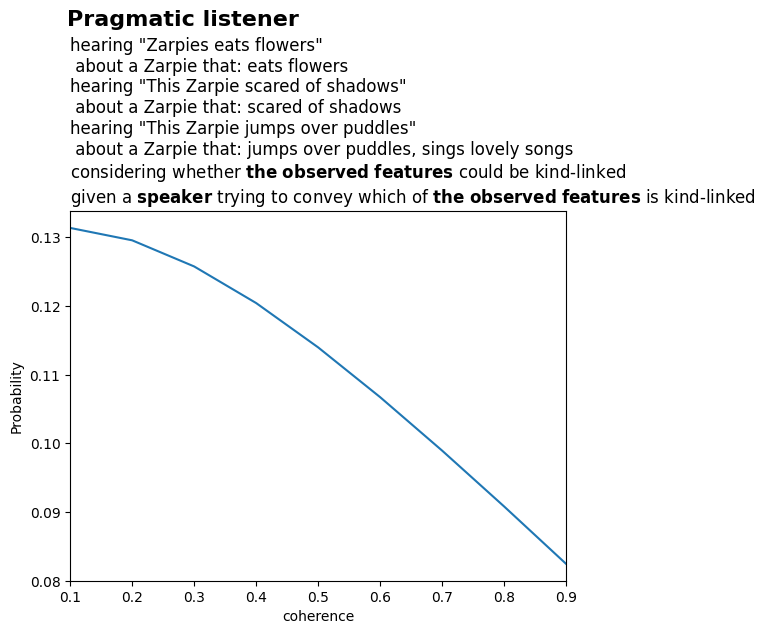

In [54]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_2_coherence.png", bbox_inches = "tight")
plt.show(g)

* hearing enough specifics can actually outweigh a generic via coherence

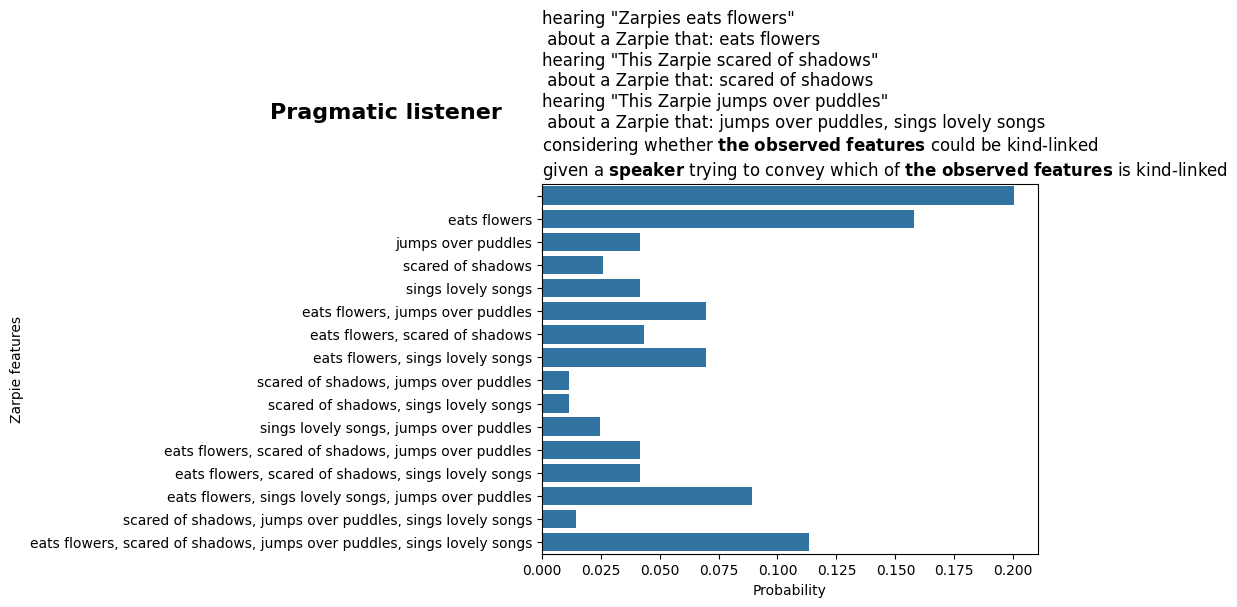

In [55]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Study 6 replication (CogSci paper draft)

In [56]:
# generic to induction study 6 (CogSci draft) - generic condition
data = (
    (Utterance("Zarpies", "love to eat flowers"), Instance("Zarpie", ("love to eat flowers", ))),
    (Utterance("Zarpies", "have stripes in their hair"), Instance("Zarpie", ("have stripes in their hair", ))),
    (Utterance("Zarpies", "can bounce a ball on their heads"), Instance("Zarpie", ("can bounce a ball on their heads", ))),
    (Utterance("Zarpies", "like to sing"), Instance("Zarpie", ("like to sing", ))),
    (Utterance("Zarpies", "climb tall fences"), Instance("Zarpie", ("climb tall fences", ))),
    (Utterance("Zarpies", "flap their arms when they are happy"), Instance("Zarpie", ("flap their arms when they are happy", ))),
    (Utterance("Zarpies", "have freckles on their feet"), Instance("Zarpie", ("have freckles on their feet", ))),
    (Utterance("Zarpies", "hop over puddles"), Instance("Zarpie", ("hop over puddles", ))),
    (Utterance("Zarpies", "hate walking in the mud"), Instance("Zarpie", ("hate walking in the mud", ))),
    (Utterance("Zarpies", "draw stars on their knees"), Instance("Zarpie", ("draw stars on their knees", ))),
    (Utterance("Zarpies", "can flip in the air"), Instance("Zarpie", ("can flip in the air", ))),
    (Utterance("Zarpies", "are scared of ladybugs"), Instance("Zarpie", ("are scared of ladybugs", ))),
    (Utterance("Zarpies", "hate ice cream"), Instance("Zarpie", ("hate ice cream", ))),
    (Utterance("Zarpies", "chase shadows"), Instance("Zarpie", ("chase shadows", ))),
    (Utterance("Zarpies", "babies are wrapped in orange blankets"), Instance("Zarpie", ("babies are wrapped in orange blankets", ))),
    (Utterance("Zarpies", "sleep in tall trees"), Instance("Zarpie", ("sleep in tall trees", )))
)

In [57]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

In [ ]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_study6_generic_coherence.png", bbox_inches = "tight")
plt.show(g)

In [ ]:
# generic to induction study 6 (CogSci draft) - specific condition
data = (
    (Utterance("This Zarpie", "love to eat flowers"), Instance("Zarpie", ("love to eat flowers", ))),
    (Utterance("This Zarpie", "have stripes in their hair"), Instance("Zarpie", ("have stripes in their hair", ))),
    (Utterance("This Zarpie", "can bounce a ball on their heads"), Instance("Zarpie", ("can bounce a ball on their heads", ))),
    (Utterance("This Zarpie", "like to sing"), Instance("Zarpie", ("like to sing", ))),
    (Utterance("This Zarpie", "climb tall fences"), Instance("Zarpie", ("climb tall fences", ))),
    (Utterance("This Zarpie", "flap their arms when they are happy"), Instance("Zarpie", ("flap their arms when they are happy", ))),
    (Utterance("This Zarpie", "have freckles on their feet"), Instance("Zarpie", ("have freckles on their feet", ))),
    (Utterance("This Zarpie", "hop over puddles"), Instance("Zarpie", ("hop over puddles", ))),
    (Utterance("This Zarpie", "hate walking in the mud"), Instance("Zarpie", ("hate walking in the mud", ))),
    (Utterance("This Zarpie", "draw stars on their knees"), Instance("Zarpie", ("draw stars on their knees", ))),
    (Utterance("This Zarpie", "can flip in the air"), Instance("Zarpie", ("can flip in the air", ))),
    (Utterance("This Zarpie", "are scared of ladybugs"), Instance("Zarpie", ("are scared of ladybugs", ))),
    (Utterance("This Zarpie", "hate ice cream"), Instance("Zarpie", ("hate ice cream", ))),
    (Utterance("This Zarpie", "chase shadows"), Instance("Zarpie", ("chase shadows", ))),
    (Utterance("This Zarpie", "babies are wrapped in orange blankets"), Instance("Zarpie", ("babies are wrapped in orange blankets", ))),
    (Utterance("This Zarpie", "sleep in tall trees"), Instance("Zarpie", ("sleep in tall trees", )))
)

In [ ]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

In [ ]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_study6_specific_coherence.png", bbox_inches = "tight")
plt.show(g)

## Speaker 2

In [55]:
@keep_deterministic
def utility_func2(pair: tuple[Utterance, Instance],
                  kind_features: tuple[str, ...]):
    # run *pragmatic* listener
    data = (pair, )
    dist = pragmatic_listener(data)
    
    utt = pair[0]
    inst = pair[1]
    
    # only seen one trial
    observed_features_so_far = inst.features
    
    # compare similarity of inferred kind-linked features to true kind features
    def f(x):
        
        # NOTE: restricted to observed features from data
        return jaccard_similarity(set(kind_features) & set(observed_features_so_far), 
                                  set(x["zarpie_features"]) & set(observed_features_so_far))
        
        ## NOTE: across all kind-linked features known to the speaker
        # return jaccard_similarity(set(kind_features), 
        #                           set(x["zarpie_features"]))
    
    # calculate expected value over all sets of features, collapsing across coherence
    exp_utility = dist.expected_value(f)
    
    return exp_utility

In [ ]:
@infer
def speaker2(kind_features: Kind.features, observed_instance: Instance, 
             inv_temp = 2):
    utt = Utterance(subj = draw_from(["Zarpies", "This Zarpie", "silence"]),       # consider saying generic or specific..
                    feature = draw_from(observed_instance.features))    # ..about some feature of observed instance
    utility = utility_func2((utt, observed_instance), kind_features)   # consider what *pragmatic* listener will infer (about zarpie features, coherence) from utterance
                                                                        # how close is *pragmatic* listener's inferences to true zarpie features
    # weight = utility**inv_temp                                        # maximize utility, with inv_temp rationality
    weight = math.exp(inv_temp*utility)                                 # version to avoid issues with 0 utility
    condition(weight)
    return utt

### Model predictions

In [57]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", ))    # observe an instance of Zarpie that has these features

# run speaker model
speaker_dist = speaker2(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)


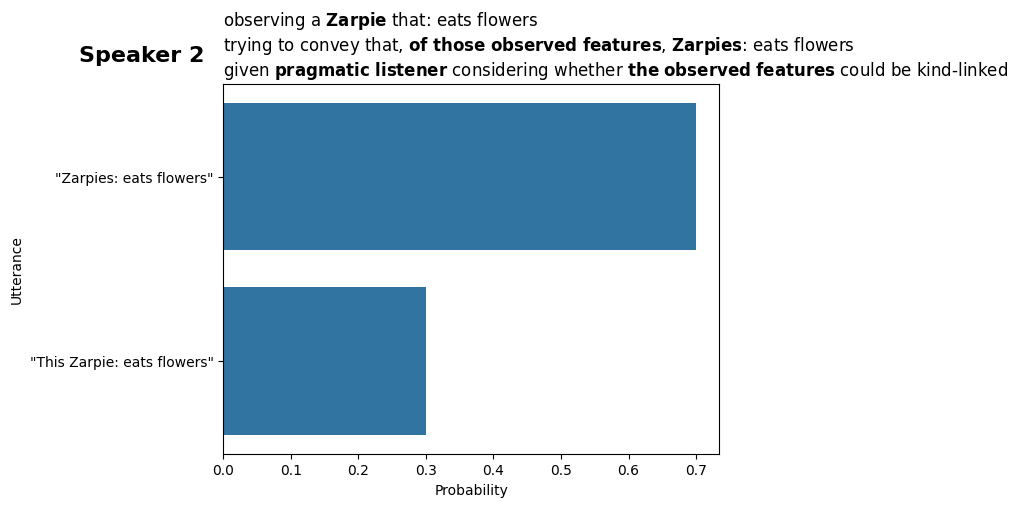

In [58]:
# convert to data frame
df_speaker_dist = dist_to_df(speaker_dist)
df_speaker_dist['Utterance'] = "\"" + df_speaker_dist['subj'] + ": " + df_speaker_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_speaker_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker 2",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{pragmatic}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker2_1kindlinked.png", bbox_inches = "tight")
plt.show(g)

#### Generic exaggeration effect

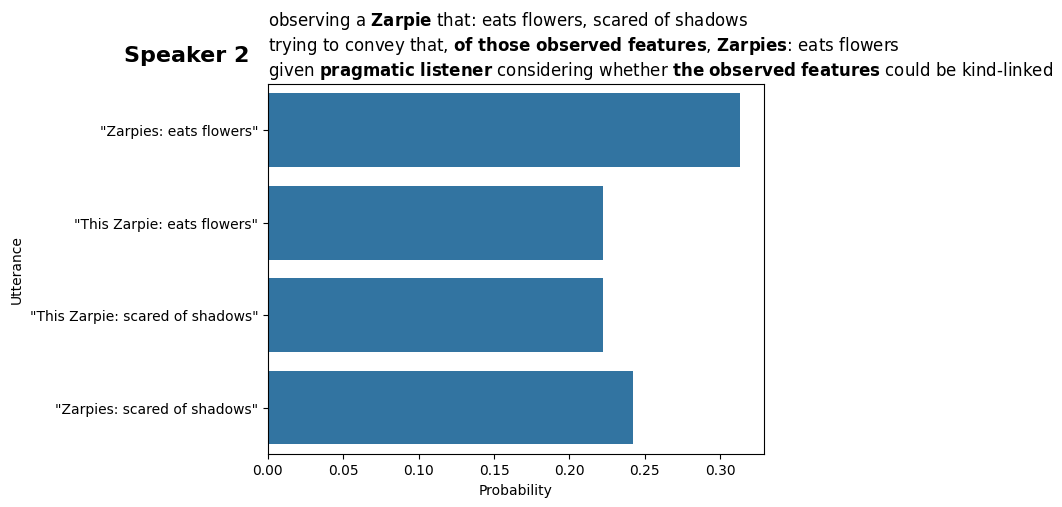

In [59]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", "scared of shadows"))             # observe an instance of Zarpie that has these features

# run speaker model
speaker_dist = speaker2(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)

# convert to data frame
df_speaker_dist = dist_to_df(speaker_dist)
df_speaker_dist['Utterance'] = "\"" + df_speaker_dist['subj'] + ": " + df_speaker_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_speaker_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker 2",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{pragmatic}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker2_1kindlinked_1notkindlinked.png", bbox_inches = "tight")
plt.show(g)